In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu

import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

import sys

seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)
import os

os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']




# Open training and testing data

In [2]:
sample_0 = np.load('toymc_0.npy')
sample_1 = np.load('toymc_1.npy')

label_train = sample_0[:,3]
sample_train = sample_0[:,0:3]
label_test = sample_1[:,3]
sample_test = sample_1[:,0:3]

# Build quantized model with Qkeras

In [ ]:
# For each layer here, we use 16 as total number of bits, and 8 as number of integer bits
# For the relu activation layer, we use 8 bits for quantization


model = Sequential()
model.add(
    QDense(
        16,
        input_shape=(3,),
        name='fc1',
        kernel_quantizer=quantized_bits(16, 8, alpha=1),
        bias_quantizer=quantized_bits(16, 8, alpha=1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
    )
)
model.add(QActivation(activation=quantized_relu(16), name='relu1'))
model.add(
    QDense(
        32,
        name='fc2',
        kernel_quantizer=quantized_bits(16, 8, alpha=1),
        bias_quantizer=quantized_bits(16, 8, alpha=1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
    )
)
model.add(QActivation(activation=quantized_relu(16), name='relu2'))
model.add(
    QDense(
        32,
        name='fc3',
        kernel_quantizer=quantized_bits(16, 8, alpha=1),
        bias_quantizer=quantized_bits(16, 8, alpha=1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
    )
)
model.add(QActivation(activation=quantized_relu(16), name='relu3'))
model.add(
    QDense(
        1,
        name='output',
        kernel_quantizer=quantized_bits(16, 8, alpha=1),
        bias_quantizer=quantized_bits(16, 8, alpha=1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
    )
)
model.add(Activation(activation='sigmoid', name='sigmoid'))


# Pruning

In [4]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

# Here, 0.1 means that 10% of the weights will be forced to be 0.
pruning_params = {"pruning_schedule": pruning_schedule.ConstantSparsity(0.1, begin_step=2000, frequency=100)}
model = prune.prune_low_magnitude(model, **pruning_params)

# Do training and save the result when the "Train" flag is true
# Or it will take the previous trained result

In [ ]:
train = True
if train:
    adam = Adam(learning_rate=0.0001)
    model.compile(optimizer=adam, loss=['binary_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(
        stop_patience=1000,
        lr_factor=0.5,
        lr_patience=10,
        lr_epsilon=0.000001,
        lr_cooldown=2,
        lr_minimum=0.0000001,
        outputDir='my_model_3',
    )
    callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
    model.fit(
        sample_train,
        label_train,
        batch_size=1024,
        epochs=30,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks.callbacks,
    )
    model = strip_pruning(model)
    model.save('my_model_3/KERAS_check_best_model.keras')
else:
    from tensorflow.keras.models import load_model
    from qkeras.utils import _add_supported_quantized_objects

    co = {}
    _add_supported_quantized_objects(co)
    model = load_model('my_model_3/KERAS_check_best_model.keras', custom_objects=co)



# Process the testing sample

In [6]:
y_keras = model.predict(sample_test)

6250/6250 [==============================] - 1s 206us/step


# Check the testing result with a cut on 0.5 and compraing to the expected label

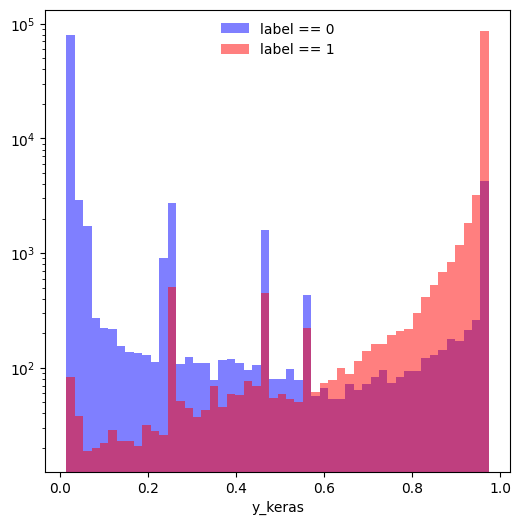

In [7]:
y_keras_sig = y_keras[ (label_test > 0 ) ]
y_keras_bkg = y_keras[ (label_test < 1) ]

plt.figure(figsize=(6,6))
plt.hist(y_keras_bkg,log=True,bins=50,label='label == 0',alpha=0.5,color='blue')
plt.hist(y_keras_sig,log=True,bins=50,label='label == 1',alpha=0.5,color='red')
plt.legend().get_frame().set_alpha(0)
plt.xlabel('y_keras')
plt.show()

Accuracy: 95.49%


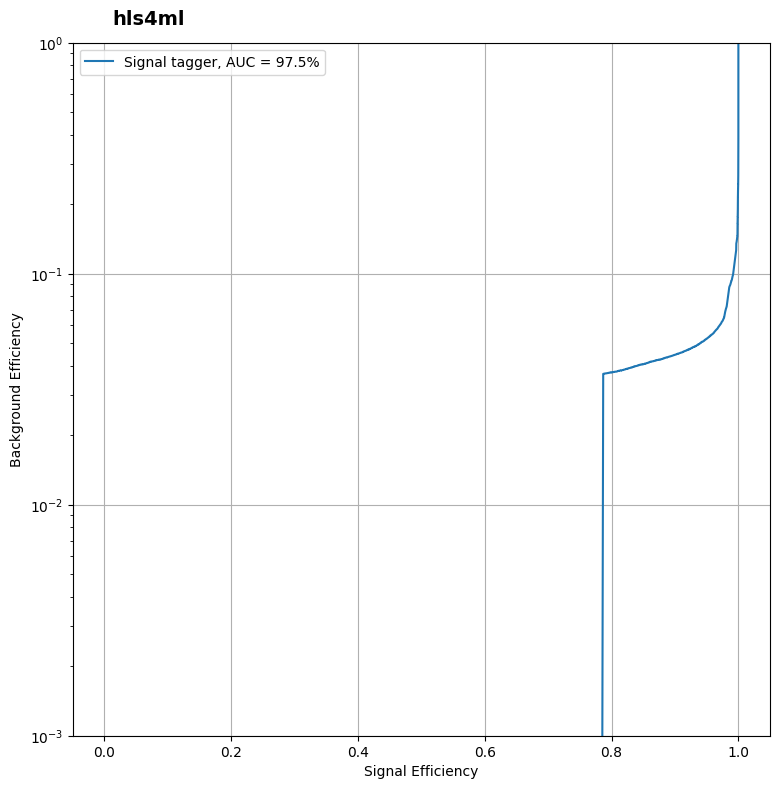

In [8]:
y_pred_binary = (y_keras > 0.5).astype(int)
accuracy = accuracy_score(label_test, y_pred_binary)
print("Accuracy: {:.2f}%".format(accuracy * 100))

label_test_reshape = label_test.reshape(len(label_test),1)
plt.figure(figsize=(9, 9))
_ = plotting.makeRoc(label_test_reshape, y_keras, ['Signal'])
plt.show()

# Build hls4ml model

In [9]:
# To create the text files to be used in later HLS Csimulation
import csv

with open('my_model_3/Input.dat', 'w') as f:
    csv.writer(f, delimiter=' ').writerows(sample_test)

with open('my_model_3/Output.dat', 'w') as f:
    csv.writer(f, delimiter=' ').writerows(y_keras)


In [10]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(model, granularity='name')

# This is for quantization on the output layer using the HLS options
# After training, you can set the quantization for each layer like this
config['LayerName']['sigmoid']['exp_table_t'] = 'ap_fixed<16,6>'
config['LayerName']['sigmoid']['inv_table_t'] = 'ap_fixed<16,6>'
config['LayerName']['sigmoid']['Precision']='ap_fixed<16,6>'

plotting.print_dict(config)
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='my_model_3/hls4ml_prj', part='xc7a200tsbg484-1',
    input_data_tb = "my_model_3/Input.dat",
    output_data_tb = "my_model_3/Output.dat"
)
# "part" is the FPGA part of the Nexys video card
# By default, it will use Vivado HLS for backend
# If you use newer version of Xilinx software, you need to include backend='Vitis' in the argument to use Vitis HLS.
# Use io_type="io_parallel" in the argument to input all the bits in parallel

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 3]], output shape: [None, 3]
Layer name: fc1, layer type: QDense, input shapes: [[None, 3]], output shape: [None, 16]
Layer name: relu1, layer type: Activation, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc2, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 1]
Layer name: sigmoid, layer type: Activation, input shapes: [[None, 1]], output shape: [None, 1]
Model
  Precision:         fixed<16,6>
  ReuseFactor:       1
  Strategy:          Latency
  BramFactor:        1000000000


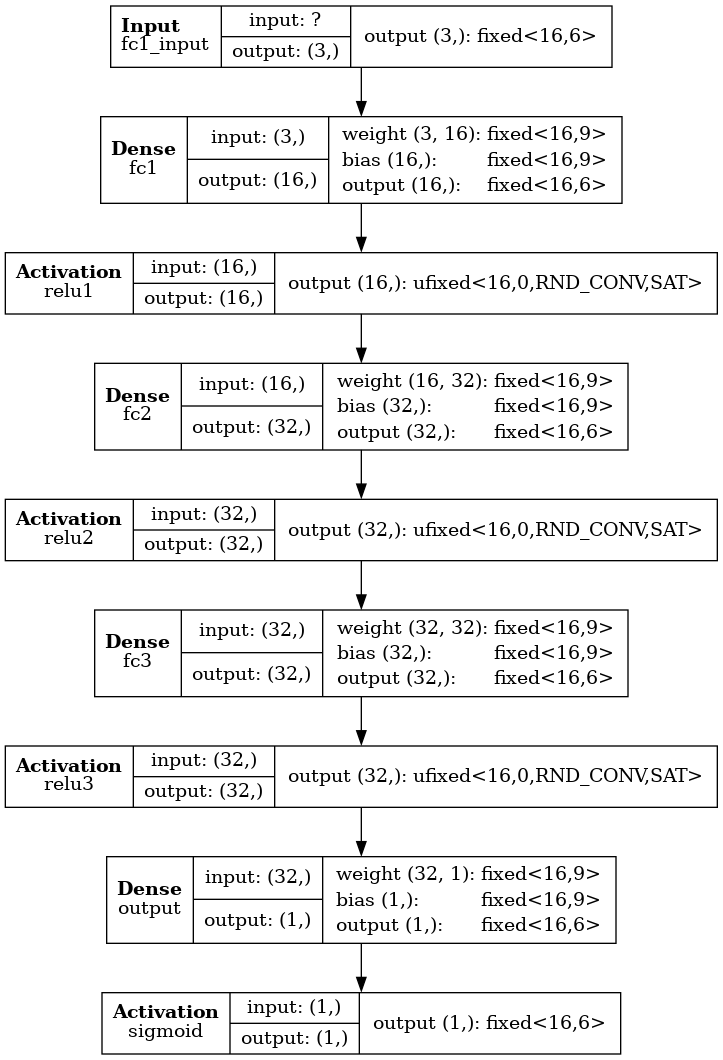

In [11]:
# This is to show the hls4ml model structure
from IPython.display import Image
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file='hls_model.png')
Image('hls_model.png')

In [12]:
# Compile it
hls_model.compile()

Writing HLS project
Done


# Process the testing data with hls4ml model and see the performance

Accuracy Keras: 95.49%
Accuracy HLS: 82.90%


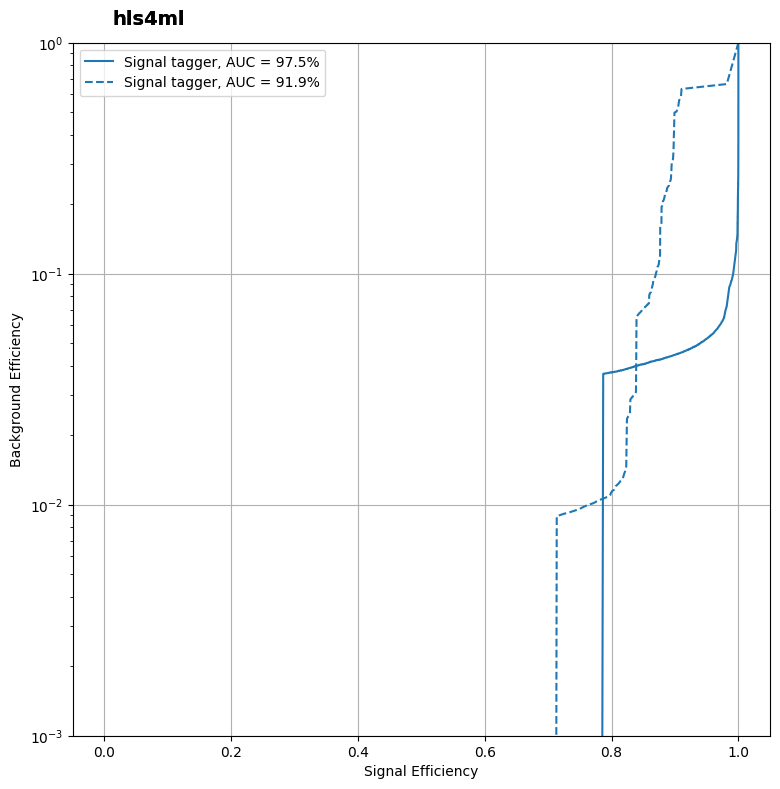

In [13]:
y_hls = hls_model.predict(np.ascontiguousarray(sample_test))

y_pred_binary_hls = (y_hls > 0.5).astype(int)
accuracy_hls = accuracy_score(label_test, y_pred_binary_hls)
print("Accuracy Keras: {:.2f}%".format(accuracy * 100))
print("Accuracy HLS: {:.2f}%".format(accuracy_hls * 100))

import matplotlib.pyplot as plt

plt.figure(figsize=(9, 9))
_ = plotting.makeRoc(label_test_reshape, y_keras, ['Signal'])
plt.gca().set_prop_cycle(None)  
_ = plotting.makeRoc(label_test_reshape, y_hls, ['Signal'], linestyle='--')
plt.show()

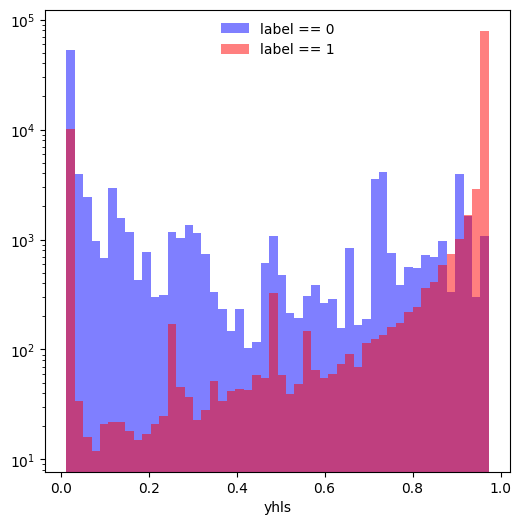

In [14]:
y_hls_sig = y_hls[ (label_test > 0 ) ]
y_hls_bkg = y_hls[ (label_test < 1) ]

plt.figure(figsize=(6,6))
plt.hist(y_hls_bkg,log=True,bins=50,label='label == 0',alpha=0.5,color='blue')
plt.hist(y_hls_sig,log=True,bins=50,label='label == 1',alpha=0.5,color='red')
plt.legend().get_frame().set_alpha(0)
plt.xlabel('yhls')
plt.show()

# Create the Vivado HLS project and do C simulation

In [ ]:
# This requires the environment variable for Xilinx Vivado being included.
# For instance, you need to run:
# source /tools/Xilinx/Vivado/2019.2/settings64.sh
# Since we set csim and cosim as True to start simulation, it takes few min.
hls_model.build(synth=True,csim=True,cosim=True)

In [ ]:
# The Vivado HLS project will be created
hls4ml.report.read_vivado_report('my_model_3/hls4ml_prj')


## Dump the predicted output data from hls4ml model to be compared to the Vivado firmware output

In [18]:
# This function will change a float into an integer under ap_fixed<N,I> format
def float_to_ap_fixed(value, N, I=8):
    F = N - I
    scaled_value = int(round(value * (1 << F)))
    if scaled_value < 0:
        scaled_value = (1 << N) + scaled_value
    scaled_value = scaled_value & ((1 << N) - 1)
    return int(scaled_value)

# This function will change a integer into hex
def to_hex(value, Nbit):
    return format(int(value), f'0{Nbit // 4}X')

y_hls_16_6 = np.vectorize(float_to_ap_fixed)(y_hls,16,6)
y_hls_hex_16_6 = np.vectorize(to_hex)(y_hls_16_6,16)


Nline = 1024

with open('text_data/predicted_hls_out.mem', 'w') as file0:
    for i in range(0,Nline):
        file0.write(f"{y_hls_hex_16_6[i][0]} \n") 